In [1]:
#!pip install tensorflow
## rm ~/.cache/pip -rf had to used this in linux terminal to clear chache from old tensorflow package
#import sys
#!{sys.executable} -m pip install latexify-py

In [24]:
import nibabel as nib
from scipy import ndimage
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## define a couple variables
#batch_size = 35
#num_channels = 1
#num_classes = 1
#image_size = 256
#latent_dim = 256

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

## for fmr min should be -1000 while max should be 400
## for t1w MRI 255 max, 0 min
def normalize(volume):
    """Normalize the volume"""
    min = 0
    max = 1200
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 150
    desired_width = 150
    desired_height = 150
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

## may have to create a def for a resize for the Ylabel directory due to the specific dims

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [2]:
tf.test.gpu_device_name()


2022-12-01 09:30:53.747216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/device:GPU:0'

2022-12-01 09:30:53.767535: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 09:30:53.789187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-01 09:30:54.364291: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 09:30:54.364327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 82 deviceMemorySize: 24.00GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-01 09:30:54.364644: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built withou

In [3]:
tf.config.experimental.list_physical_devices()

2022-12-01 09:30:57.493308: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-01 09:30:57.493845: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 09:30:57.493870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 82 deviceMemorySize: 24.00GiB deviceMemoryBandwidth: 871.81GiB/s
2022-12-01 09:30:57.494171: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-01 09:30:57.494186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusI

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
pwd

'/home/moonanul'

In [25]:
Gz_paths = [os.path.join(os.getcwd(), "cGANimages/Gz", x)
    for x in os.listdir("cGANimages/Gz")]


# Folder "" 



Ylabel_paths = [os.path.join(os.getcwd(), "cGANimages/Ylabel", x)
    for x in os.listdir("cGANimages/Ylabel")]


t1wRaw_paths = [os.path.join(os.getcwd(), "cGANimages/t1wRaw", x)
    for x in os.listdir("cGANimages/t1wRaw")]
    

#T1wmixRaw_paths = [os.path.join(os.getcwd(), "cGANimages/T1wmixRaw", x)
   # for x in os.listdir("cGANimages/T1wmixRaw")]



print("T1w MRI (Gz) smoothed + motion corrected: " + str(len(Gz_paths)))
print("T1w MRI conditional (Y) L/R hippocampus label, text and voxel: " + str(len(Ylabel_paths)))
print("T1w MRI raw (Xr): " + str(len(t1wRaw_paths)))

T1w MRI (Gz) smoothed + motion corrected: 166
T1w MRI conditional (Y) L/R hippocampus label, text and voxel: 2
T1w MRI raw (Xr): 166


In [26]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
Gz_scans = np.array([process_scan(path) for path in Gz_paths])
t1wRaw_scans = np.array([process_scan(path) for path in t1wRaw_paths])
Ylabel = np.array([process_scan(path) for path in Ylabel_paths])
## may need to mess with sizing for ylabel


# For the CT scans having presence of viral pneumonia
# assign 1, for hippocampus labeled in image assign 0 for unlabeled image.
#Ylabel_labels = np.array([1 for _ in range(len(Gz_scans))])
#Ylabel_labels = np.array([0 for _ in range(len(normal_scans))])

## Split data in the ratio 70/30 for training and validation.
## x train set as Gz and y train set as Xr or t1Raw
## since y, dependent var should stay the same which is the discriminator

x_train = np.concatenate((Gz_scans[:116], Ylabel[:]), axis=0)
y_train = np.concatenate((t1wRaw_scans[:116], Ylabel[:]), axis=0)
#Gzy_train = np.concatenate((abnormal_labels[:116], normal_labels[:70]), axis=0)
x_test = np.concatenate((Gz_scans[116:], Ylabel[:]), axis=0)
y_test = np.concatenate((t1wRaw_scans[116:], Ylabel[:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_test.shape[0])
)

BadGzipFile: CRC check failed 0x183b1a6d != 0x41f1a07a

In [8]:

x_train.shape

(118, 150, 150, 150)

In [27]:

##@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [28]:
batch_size = 35
num_channels = 1
num_classes = 2
#image_size = 150
latent_dim = 150

##XX_data = np.concatenate([x_train, x_test])
##YY_data = np.concatenate([y_train, y_test])

#dataset = tf.data.Dataset.from_tensor_slices((XX_data, YY_data))
#dataset = dataset.shuffle(buffer_size=200).batch(batch_size)

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch_size = 30
## define a couple variables
#batch_size = 35
#num_channels = 1
#num_classes = 1
#image_size = 256
#latent_dim = 150

## train loader
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
## train test loader
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(30)
)

In [29]:
import random

Dimension of the T1w MRI scan is: (150, 150, 150, 1)


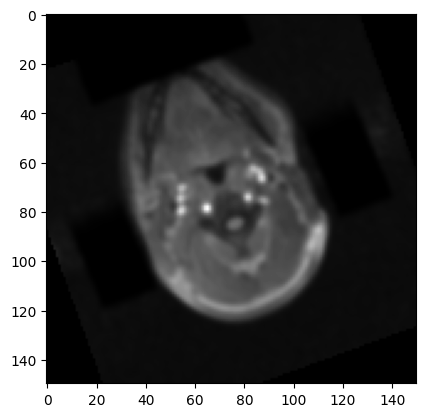

In [31]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the T1w MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

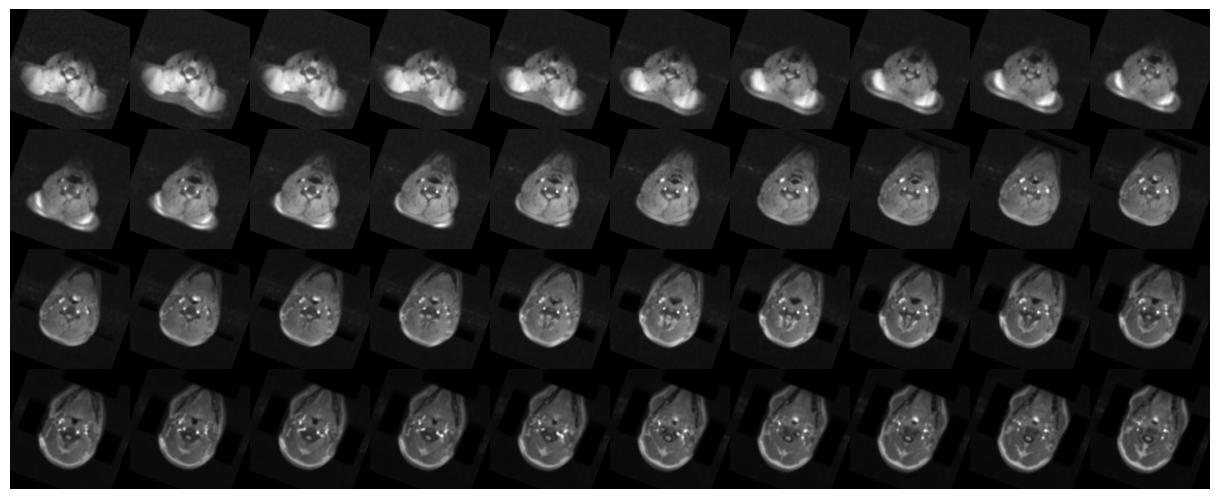

In [32]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


## Visualize montage of slices.
plot_slices(4, 10, 150, 150, image[:, :, :40])

In [33]:
##def channel, class and img_size vars

#num_channels = 1
#num_classes = 2
#image_size = 150


generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

152 3


In [71]:
# define the standalone discriminator model
def define_discriminator(in_shape=(150,150,150,1), n_classes=2):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
## defining discriminator, multiple iterations with  ** changed dense layer from 500-->300, 10% mem exceeded

#inputs = keras.Input((width=150, height=150, depth=150, 1))

discriminator = keras.Sequential(
    [
        #tf.keras.layers.InputLayer(input_shape=(150, 150, 150, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
     
        
        
        
        #tf.keras.layers.InputLayer(input_shape=( 150, 1)),
        #layers.Conv2D(200, (3, 3), strides=(2, 2), padding="same"),
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.GlobalMaxPooling2D(),
        #layers.Dense(1),
    ],
    name="discriminator",
)

# old iteration of generator.
#generator = keras.Sequential(
 #   [
  #      keras.layers.InputLayer((150, 150, generator_in_channels)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
   #     layers.Conv2D(200, (3, 3), strides=(2, 2), padding="same"),
    #    layers.BatchNormalization(),
     #   layers.LeakyReLU(alpha=0.2),
      ## layers.LeakyReLU(alpha=0.2),
        #layers.Conv2D(200, (3, 3), strides=(2, 2), padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),
        #layers.Reshape((150, 150, generator_in_channels)),
        #layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
       
        
    #],
    #name="generator",
#)

generator = keras.Sequential(
    [
        #tf.keras.layers.InputLayer(input_shape=(, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
         
        
        
        
        
        
        
       # tf.keras.layers.InputLayer(input_shape=(, 150, 150, 150, 1)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        
        #layers.Dense(450),
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(alpha=0.2),
        
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(alpha=0.2),
        
        #layers.Conv3D(filters=150, kernel_size=3, activation="relu"),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(alpha=0.2),
        #layers.Dropout(0.3),
        #layers.GlobalMaxPooling2D(),
        #layers.Dense(1),
         
    ],
    name="generator",
)

## 3d CNN model, need correct notation
#def get_model(width=128, height=128, depth=64):
    #"""Build a 3D convolutional neural network model."""

    #inputs = keras.Input((width, height, depth, 1))

    #x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    #x = layers.MaxPool3D(pool_size=2)(x)
    #x = layers.BatchNormalization()(x)

    #x = layers.GlobalAveragePooling3D()(x)
    #x = layers.Dense(units=512, activation="relu")(x)
    #x = layers.Dropout(0.3)(x)

    #outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    #model = keras.Model(inputs, outputs, name="3dcnn")
    #return model


# Build model.
#model = get_model(width=128, height=128, depth=64)
#model.summary()

In [68]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [69]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "Hippvol_image_classification.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
#epochs = 20
#model.fit(
#    train_dataset,
#    validation_data=validation_dataset,
#    epochs=epochs,
#    shuffle=True,
#    verbose=2,
#    callbacks=[checkpoint_cb, early_stopping_cb],
#)
#gaugan.compile()
#history = gaugan.fit(
#    train_dataset,
#    validation_data=val_dataset,
#    epochs=15,
#    callbacks=[GanMonitor(val_dataset, BATCH_SIZE)],
#)

cond_gan.fit(train_dataset, epochs=20, callbacks=[checkpoint_cb, early_stopping_cb])
cond_gan.summary()

Epoch 1/20


ValueError: in user code:

    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /tmp/ipykernel_577/3580991076.py:38 train_step
        random_vector_labels = tf.concat(
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:1677 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/ops/gen_array_ops.py:1207 concat_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/moonanul/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 2 but is rank 4 for '{{node concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](random_normal, IteratorGetNext:1, concat/axis)' with input shapes: [?,150], [?,150,150,150], [].


In [ ]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 1  # @param {type:"slider", min:0, max:9, step:1}
end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)
embed.embed_file("animation.gif")

In [ ]:
## SSIM

from skimage.metrics import structural_similarity as ssim